# Wave propagation (hyperbolic PDE)

## libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib import animation
from IPython.display import HTML

## initialization

In [2]:
COURANT = 0.7

X_max = 100
T_max = 400
X_min = - X_max
T_min = 0
AMP   = 10
WIDTH = X_max / 10

NUMBER_X = 100
NUMBER_T = int((T_max - T_min) * NUMBER_X / COURANT / (X_max - X_min))

In [3]:
X_RANGE = np.linspace(X_min, X_max, NUMBER_X)
T_RANGE = np.linspace(T_min, T_max, NUMBER_T)

X_STEP = X_RANGE[1] - X_RANGE[0]
T_STEP = T_RANGE[1] - T_RANGE[0]

In [4]:
X, T = np.meshgrid(X_RANGE, T_RANGE, indexing='ij')

In [5]:
def source(x):
    return np.exp(- x ** 2 / 2 / AMP ** 2)

def initial_state():
    E = np.zeros_like(X)
    H = np.zeros_like(X)
    sigma = np.zeros_like(X_RANGE)

    E[:, 0] = source(X_RANGE)
    
    return E, H, sigma


def PML(sigma, x):
    mask_left  = x < X_min + WIDTH
    mask_right = x > X_max - WIDTH

    sigma[mask_left]  = 0.004 * AMP * ((x[mask_left]  + X_max - WIDTH) / WIDTH) **2
    sigma[mask_right] = 0.004 * AMP * ((x[mask_right] + X_min + WIDTH) / WIDTH) **2
    
    return sigma

def wave_equation_solution():
    E, H, sigma = initial_state()
    
    for x in range(1, len(X_RANGE) - 1):
        E[x, 1] = E[x, 0] + (E[x+1, 0] - 2 * E[x, 0] + E[x-1, 0]) * COURANT ** 2 / 2

    for t in range(1, len(T_RANGE) - 1):
        for x in range(1, len(X_RANGE) - 1):
            E[x, t+1] = 2 * E[x, t] - E[x, t-1] + (E[x+1, t] - 2 * E[x, t] + E[x-1, t]) * COURANT ** 2
            
    return E

def maxwell_system_solution(space=None):
    E, H, sigma = initial_state()
    sigma_ = sigma.copy()
    
    if space == 'PML':
        sigma  = PML(sigma, X_RANGE)
        sigma_ = PML(sigma[:-1], ((np.roll(X_RANGE, -1) + X_RANGE) / 2)[:-1])
    
    s  = 2 * np.pi * sigma  * T_STEP
    s_ = 2 * np.pi * sigma_ * T_STEP
        
    for x in range(len(X_RANGE) - 1):
        H[x, 0] = (source(X_RANGE)[x+1] - source(X_RANGE)[x]) * COURANT / 2

    for t in range(0, len(T_RANGE) - 1):
        for x in range(1, len(X_RANGE) - 1):
            E[x, t+1] = (E[x, t] * (1 - s[x]) + (H[x, t] - H[x-1, t]) * COURANT) / (1 + s[x])

        for x in range(0, len(X_RANGE) - 1):
            H[x, t+1] = (H[x, t] * (1 - s_[x]) + (E[x+1, t+1] - E[x, t+1]) * COURANT) / (1 + s_[x])
            
    return E

def exact_solution(x, t):
    return (source(x - t) + source(x + t)) / 2
    
def animation_plot(E):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axis([X_min, X_max, E.min(), E.max()])

    l1, = ax.plot(X_RANGE, E[:, NUMBER_T - 1], lw=3, color='black', label=NUMBER_T)
    l2, = ax.plot(X_RANGE, E_exact[:, NUMBER_T - 1], lw=2, color='red')
    ax.grid(c='#aaaaaa', ls='--')

    ax.set_ylabel("f(x)")
    ax.set_xlabel("x")

    def animate(i):
        l1.set_data(X_RANGE, E[:, i])
        l1.set_label('t = ' + '%.3f' % (i * T_STEP))
        l2.set_data(X_RANGE, E_exact[:, i])

        legend = plt.legend(loc='upper right')
        return l1, l2, legend

    ani = animation.FuncAnimation(fig, animate, frames= np.arange(0, NUMBER_T, 5), interval=60)

    #ani.save("solution.mp4")
    return HTML(ani.to_jshtml())


## main procedure

In [6]:
E_simple = wave_equation_solution()
E_maxwell= maxwell_system_solution()
E_maxwell_free= maxwell_system_solution('PML')
E_exact = exact_solution(X, T)

## animated plot

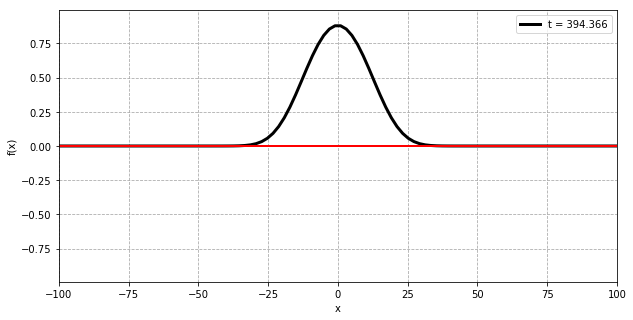

In [7]:
animation_plot(E_simple)

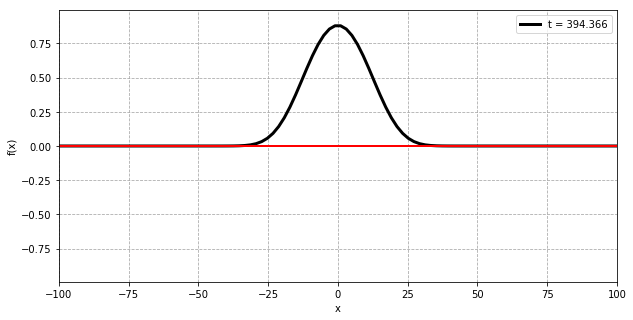

In [8]:
animation_plot(E_maxwell)

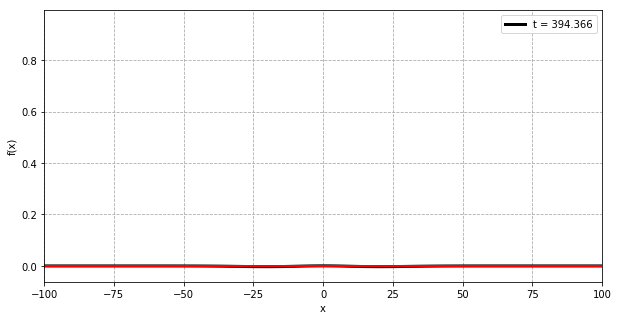

In [9]:
animation_plot(E_maxwell_free)